# 0. Import Dependencies

In [2]:
# Environment stuff
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
from gym.error import DependencyNotInstalled
from datetime import time as tim, datetime, timedelta

# Deep Q-Learning
import utils

# Deep Learning
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MSE

# PID
from scipy.integrate import odeint

# Helper functions 
import random
import numpy as np
import time
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from typing import Optional

In [3]:
# Set hyperparameters
TAU = 1e-3
GAMMA = 0.995
ALPHA = 1e-3

# epsilon greedy strategy
EPSILON = 1
E_MIN = 0.01
E_DECAY = 0.9975

# Experience Replay
MEMORY = 1000  
BATCH_SIZE = 20 
NUM_STEPS_UPD = 4

# Training 
NUM_EPISODES = 3000

In [4]:
n = 96 # number of 15min periods in a day
MIN_TEMP_SUMMER = 12
MAX_TEMP_SUMMER = 25
SETPOINT_SUMMER = np.ones(n) * 21

MIN_TEMP_WINTER = 0
MAX_TEMP_WINTER = 14

# 1. Setting up Environment

## 1.1 Outdoor Temperature

In [5]:
# make intervals list for plotting
start_time = datetime.strptime("00:00", "%H:%M")
intervals = []
intervals = [(start_time + timedelta(minutes = 15 * i)).time() for i in range(0,96)]
intervals = [time.strftime("%H:%M") for time in intervals]

In [6]:
t = np.linspace(0,95,n)

o_temp_summer_wo_noise = MIN_TEMP_SUMMER + (MAX_TEMP_SUMMER - MIN_TEMP_SUMMER) * np.sin(np.pi * t /96)**2

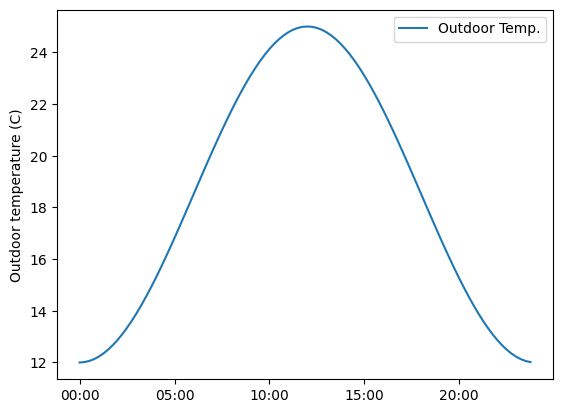

In [7]:
plt.plot(intervals, o_temp_summer_wo_noise)
plt.ylabel('Outdoor temperature (C)'); plt.legend(['Outdoor Temp.'])
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))

plt.show()

In [24]:
o_temp_summer = [(MIN_TEMP_SUMMER + (MAX_TEMP_SUMMER - MIN_TEMP_SUMMER) * np.sin(np.pi * x /96)**2) + random.uniform(-0.5,0.5) for x in t]

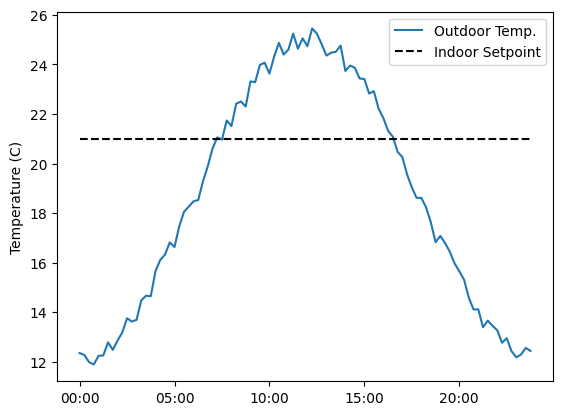

In [9]:
plt.plot(intervals, o_temp_summer,label='Outdoor Temp.')
plt.plot(intervals, SETPOINT_SUMMER,'k--',label='Indoor Setpoint')
plt.ylabel('Temperature (C)') ; plt.legend(loc='best')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))

plt.show()

## 1.2 Heat Transfer equation
### Equation taken from a GitHub Project (in use)
$$T^i_{t+1} = T^i_t + (h \times action) + [l \times (T^o_t - T^i_t)]$$
where: <br>
$T^i_t$ is the indoor temperature at timestep t <br>
$T^o_t$ is the outdoor temperature at timestep t <br>
$dt$ is the timestep = 15mins <br>
$h$ is the heating power <br>
$l$ is the loss coefficient

### Principle of Heat Transfer (not used)
$$\frac{dT_i}{dt} = \frac{1}{R \times C} (T_o - T_i) + \frac{Q_h}{C}$$ <br>
where: <br>
$T_i$ is indoor temperature <br>
$T_o$ is outdoor temperature <br>
$R$ is the thermal resistance of the building envelope ($\degree C/W$) <br>
$C$ is thermal capacity of the building ($J/\degree C$) <br>
$Q_h$ is the heating input power ($W$)


## 1.3 Environment Class
The following environment simulates the internal temperature of a box model for a single day in Summer. The day runs from 00:00 to 23:45, a total of 96 fifteen minute periods. The starting internal temperature is initialised randomly between 18 and 20 deg C.

In [26]:
o_temp_summer

[12.293325084130224,
 11.596289987145724,
 12.168391506110945,
 12.111339879348169,
 12.35162946953253,
 12.69003173395333,
 12.237818660738492,
 12.901816400828375,
 12.487969168609666,
 12.815908056901286,
 13.637786259817547,
 13.445577400606304,
 14.2197190188211,
 13.814859722065648,
 14.18940920035562,
 15.086464125563824,
 14.795234067865612,
 15.698989550365658,
 16.422573704325956,
 16.444841443790175,
 16.998265339395875,
 16.758609701557372,
 17.78657966048112,
 18.181218077758288,
 18.575952948031542,
 18.816329749318758,
 19.21856018976552,
 20.2486037437521,
 19.718715830777867,
 20.110993034325578,
 21.448473590612693,
 21.05984842782095,
 21.373895164424432,
 21.821783024514062,
 22.757695878910866,
 23.222716956795026,
 22.618976653381218,
 23.312577580580168,
 23.258296931267196,
 23.664472369759377,
 23.84999439591517,
 24.4765985397978,
 24.355510928719895,
 24.33536374324787,
 24.78215437608883,
 24.414483029705693,
 24.545312840118736,
 25.474318149773424,
 24.699

In [10]:
class RoomSimulator(Env):
    """
    ### Description

    This environment simulates a room's internal temperature profile for a Summer's day in the UK. 

    ### Action Space

    The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction
    of the fixed force the cart is pushed with.

    | Num | Action         |
    |-----|----------------|
    | 0   | Heating is off |
    | 1   | Heating is on  |

    ### Observation Space

    The observation is a `ndarray` with shape `(1,)` with the values corresponding to the following:

    | Num | Observation     | Min                | Max               |
    |-----|-----------------|--------------------|-------------------|
    | 0   | Room Temperature| -20                | 60                |

    ### Rewards

    Since the goal is to keep the room's temperature as close to the setpoint temperature, rewards are based on bands:
    - Reward of `+1` is awarded for every step taken when the room's temperature is within 0.5C of the setpoint. 
    - Reward of '+0.6' is awarded for every step taken when the room's temperature is within 0.5C - 1C of the setpoint.
    - Reward of '+0.3' is awarded for every step taken when the room's temperature is within 1C - 1.5C of the setpoint.
    - Reward of '0' is awarded for every step taken when the room's temperature is more than 1.5C away from the setpoint.

    ### Starting State

    Room temperature is assigned a uniformly random value in `(18, 20)`

    ### Episode End

    The episode ends when the day is over or 96 fifteen minute intervals have elapsed. 
    
    """

    metadata = {
        "render_fps":12
    }
    
    def __init__(self, heating_power, loss_coefficient, render_mode: Optional[str] = None):

        # spaces
        self.observation_space = Box(low = -20, high = 60, shape = (1,))
        self.action_space = Discrete(n = 2)

        # parameters
        self.h = heating_power
        self.l = loss_coefficient
        self.num_timesteps = np.arange(0,len(t))

        # render
        self.render_mode = render_mode
        self.screen = None
        self.clock = None
        
        self.black = (0,0,0)
        self.white = (255,255,255)
        self.blue = (0,0,255)
        self.green = (0,255,0)

        self.screen_width = 1800
        self.screen_height = 800
        self.chart_xoffset = 100
        self.chart_yoffset = 100
        self.chart_width = 1200
        self.chart_height = 600

        # chart-specific parameters
        self.origin = (140, 660)
        self.xtick = 11.6665 # pixels/15min
        self.ytick = 104/5 # pixels/degC
        
        

    def step(self,action):

        # record previous state for rendering
        self.old_state = self.state
        
        # update state (indoor temperature)
        self.state += (self.h*action) + (self.l*(self.otemp[self.current_timestep] - self.state))

        # reward mechanism
        if abs(self.setpoint[int(self.current_timestep)] - self.state) <= 0.5: reward = 1
        elif 0.5 < abs(self.setpoint[int(self.current_timestep)] - self.state) <= 1: reward = 0.6
        elif 1 < abs(self.setpoint[int(self.current_timestep)] - self.state) <= 1.5: reward = 0.3
        else: reward = 0

        # is the day finished?
        if self.current_timestep == len(t) -1:
            done = True
        else:
            done = False

        self.current_timestep += 1
        self.score += reward
        info = {self.score}

        return self.state, reward, done, info
            
    def reset(self):
        
        self.state = random.uniform(18,20)
        self.otemp = o_temp_summer
        self.setpoint = SETPOINT_SUMMER
        self.current_timestep = 0
        self.score = 0
        
        return self.state

    def render(self):
        
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                'You can specify the render_mode at initialization e.g. RoomSimulator(...,render_mode= "human")'
            )
            return 

        try:
            import pygame
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install pygame`"
            )

        if self.screen is None:
            pygame.init()
            pygame.display.init()
            if self.render_mode == "human":
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:
                gym.logger.warn(
                    "You have specified an unknown render_mode"
                )
                return

        if self.clock is None:
            self.clock = pygame.time.Clock()
        
        font = pygame.font.Font(None, 30)
        font_big = pygame.font.Font(None, 50)
        
        # Fixed Elements
        # chart
        self.screen.fill(self.white)
        chart_rect = pygame.Rect(self.chart_xoffset,self.chart_yoffset,self.chart_width,self.chart_height)
        pygame.draw.rect(self.screen,self.black,chart_rect,2)
        
        # time labels
        for i in range(5):
            x = self.origin[0] + i * (self.xtick*4*5)
            pygame.draw.line(self.screen, self.black, (x, self.chart_yoffset + self.chart_height), (x, self.chart_yoffset + self.chart_height + 10))
            time_label = font.render(f'{i*5:02}:00', True, self.black)
            self.screen.blit(time_label,(x-20, self.chart_yoffset + self.chart_height + 20))

        # temperature labels
        for i in range(6):
            y = self.origin[1] + -i * (self.ytick*5)
            pygame.draw.line(self.screen,self.black,(100,y),(90,y))
            temp_label = font.render(f"{15+i*5}",True,self.black)
            self.screen.blit(temp_label,(65, y-7.5))
    
        y_axis_label = pygame.transform.rotate(font.render('Room Temperature (°C)', True, self.black),90)
        y_axis_label_rect = y_axis_label.get_rect(center = (self.chart_xoffset/2 - 10,self.screen_height/2))
        self.screen.blit(y_axis_label, y_axis_label_rect)

        # score box
        score_rect = pygame.Rect(1350,100,400,150)
        pygame.draw.rect(self.screen, self.black,score_rect, 2)
        reward_text = font_big.render("Reward",True,self.black)
        self.screen.blit(reward_text, (1400, 150))

        # dynamic elements
        
        pygame.draw.line(self.screen, self.black, (self.origin[0],self.old_state),(self.origin[0] + 30, self.state))
        
        # draw elements
        self.clock.tick(self.metadata["render_fps"]) 
        pygame.event.pump() # seems to not crash when I try to close the pygame window if I include this line
        pygame.display.update()

    def close(self):
        import pygame
        
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
        

## 1.4 Test Environment

In [11]:
env = RoomSimulator(1,0.025,render_mode="human")
state_shape = np.shape(np.expand_dims(env.reset(), axis = 0))
print("State Shape:",state_shape)

State Shape: (1,)


In [12]:
for ep in range(1):
    done = False
    state = env.reset()
    ts = np.zeros(len(t))
    score = 0
    i = 0

    while not done:
        state, reward, done, info = env.step(env.action_space.sample())
        env.render()
        score += reward
        state = np.expand_dims(state, axis = 0)

        ts[i] = state[0]  
        i += 1
        
        if done:
            break
    print(f'Episode {ep + 1}: Score: {score:.2f}')
env.close()

Episode 1: Score: 6.00


Episode 1: Score: 4.70
Episode 2: Score: 11.70
Episode 3: Score: 5.40


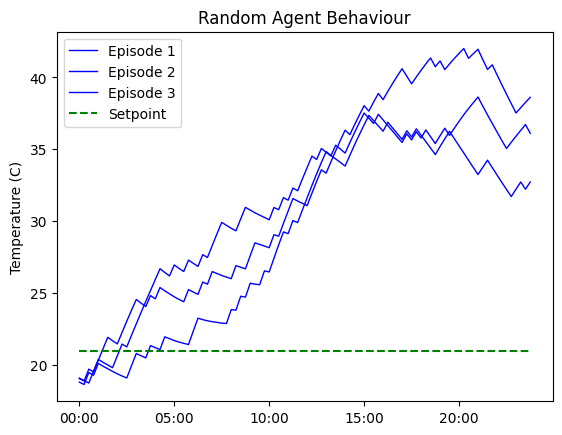

In [12]:
all_ts = []

for ep in range(3):
    done = False
    state = env.reset()
    ts = np.zeros(len(t))
    score = 0
    i = 0

    while not done:
        state, reward, done, info = env.step(env.action_space.sample())
        score += reward
        state = np.expand_dims(state, axis = 0)
        
        ts[i] = state[0]  
        i += 1
        if done:
            break
    print(f'Episode {ep + 1}: Score: {score:.2f}')
    all_ts.append(ts)
env.close()

for ep, ts in enumerate(all_ts, start =1):
    plt.plot(intervals, ts, 'b-', label = f'Episode {ep}', linewidth = 1)
plt.plot(intervals, SETPOINT_SUMMER, 'g--', label = 'Setpoint')
plt.title('Random Agent Behaviour')
plt.ylabel('Temperature (C)') ; plt.legend(loc='best')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))
plt.show()

# 2. Train Agent

## 2.1 Helper Functions

In [15]:
# @tf.function allows computations to be carried out in graph-mode instead of eager execution
@tf.function
def agent_learn(policy_network, target_network, experiences, gamma, tau):
    """
    Agent performs a gradient descent step in the policy network &
    updates weights within the target network using a softmax update.

    Args:
        policy_network (Sequential):
            Policy network used to predict the best action in the env
        target_network (Sequential):
            Network outputting the targets (optimal sets of Q-values)
        experiences (tuple):
            tuple of experiences in the form (states, actions, reward, new_states, done_vals)
        gamma (float):
            Discount factor used in Bellman's equation
    """
    # tf needs to know what operations happened during the forward pass, and in what order, so 
    # that it can use back-propagation to compute gradients
    with tf.GradientTape() as tape:
        # forward pass
        loss = utils.compute_loss_tf(policy_network, target_network, experiences, gamma)

    # backward pass
    gradients = tape.gradient(loss, policy_network.trainable_variables)

    # perform a gradient descent step in policy network
    optimizer.apply_gradients(zip(gradients, policy_network.trainable_variables))

    # update target network
    utils.update_target_network(target_network, policy_network, tau)

## 2.2 Networks

In [16]:
policy_network = Sequential(
    [
        Input(shape = state_shape),
        Dense(units = 64, activation = 'relu'),
        Dense(units = 64, activation = 'relu'),
        Dense(units = 3, activation = 'linear')
    ]
)

target_network = Sequential(
    [
        Input(shape = state_shape),
        Dense(units = 64, activation = 'relu'),
        Dense(units = 64, activation = 'relu'),
        Dense(units = 3, activation = 'linear')
    ]
)

optimizer = Adam(learning_rate = ALPHA)

In [17]:
target_network.set_weights(policy_network.get_weights())

## 2.3 Experiences

In [18]:
experiences = namedtuple('Experience', 'state, action, reward, new_state, done_val')

In [19]:
memory_buffer = deque(maxlen = MEMORY)

## 2.4 Train Network

In [20]:
start_time = time.time()
epsilon = EPSILON
score_hist = []
ts_list = []
num_ep_avg = 200
best_avg_score = 0

for ep in range(NUM_EPISODES):
    # standard resets
    done = False
    score = 0
    state = env.reset()

    # temperature array
    ts = np.zeros(len(env.num_timesteps))
    ts[0] = state

    for i in range(1, len(env.num_timesteps)+1):

        # epsilon-greedy strategy
        state_net = np.expand_dims(state, axis = 0)
        q_values = policy_network(state_net)
        action = utils.choose_action(env, epsilon, q_values)

        # take action & store experience
        new_state, reward, done, info = env.step(action)
        experience = experiences(state, action, reward, new_state, done)
        memory_buffer.append(experience)

        # update networks?
        if utils.check_update(i, NUM_STEPS_UPD, memory_buffer, BATCH_SIZE):
            exps = utils.get_experiences(memory_buffer, BATCH_SIZE)
            agent_learn(policy_network, target_network, exps, GAMMA, TAU)

        # reset state and update score
        state = new_state
        if i < len(env.num_timesteps): ts[i] = state
        score += reward

        # is the episode over?
        if done:
            break

    # append results
    score_hist.append(score)
    score_avg = np.mean(score_hist[-num_ep_avg:])

    # update epsilon
    epsilon = utils.update_epsilon(epsilon, E_MIN, E_DECAY)

    # output metrics every 200 episodes
    if (ep + 1) % num_ep_avg == 0:
        print(f'Episode {ep + 1}: Average Reward over the last {num_ep_avg} episodes: {score_avg}')
        ts_list.append(ts)
    if score_avg > best_avg_score:
        policy_network.save('best_model.keras')
        best_avg_score = score_avg
        
policy_network.save('final_policy_network.keras')
target_network.save('final_target_network.keras')
time_taken = time.time() - start_time
print(f"Training for {NUM_EPISODES} episodes took {time_taken/60:.0f} minutes")

Episode 200: Average Reward over the last 200 episodes: 5.359
Episode 400: Average Reward over the last 200 episodes: 4.301
Episode 600: Average Reward over the last 200 episodes: 12.621000000000004
Episode 800: Average Reward over the last 200 episodes: 24.113500000000002
Episode 1000: Average Reward over the last 200 episodes: 36.73950000000001
Episode 1200: Average Reward over the last 200 episodes: 44.43450000000001
Episode 1400: Average Reward over the last 200 episodes: 53.281499999999994
Episode 1600: Average Reward over the last 200 episodes: 56.38949999999999
Episode 1800: Average Reward over the last 200 episodes: 57.379499999999986
Episode 2000: Average Reward over the last 200 episodes: 57.65249999999998
Episode 2200: Average Reward over the last 200 episodes: 58.46899999999999
Episode 2400: Average Reward over the last 200 episodes: 58.39199999999999
Episode 2600: Average Reward over the last 200 episodes: 60.40499999999998
Episode 2800: Average Reward over the last 200 ep

## 2.5 Saving Results

In [63]:
import pickle

In [68]:
# Save scores 
with open('score_hist.pkl', 'wb') as file:
    pickle.dump(score_hist, file)

In [69]:
# Save temperature arrays for each 200 timesteps
with open('ts_list.pkl', 'wb') as file:
    pickle.dump(ts_list, file)

## 2.6 Loading Results

In [70]:
with open('score_hist.pkl', 'rb') as file:
    score_hist = pickle.load(file)

In [71]:
with open('ts_list.pkl', 'rb') as file:
    ts_list = pickle.load(file)

# 3. Compare with PID Controller 

In [ ]:
def heat_transfer(Ti, t, To, R, C, Qh):
    dTidt = 1/(R*C) * (To-Ti) + Qh/C

    return dTidt

# initial condition
Ti0 = 20
Ti = np.zeros_like(t)
Ti[0] = Ti0

# System parameters
R = 5.0
C = 1000.0 
Qh_min = 0
Qh_max = 500
Qh0 = 0
Qh = np.zeros_like(t)
Qh[0] = Qh0

# PID stuff
Kp = 40
Ki = 8
Kd = 1

e = np.zeros(len(t)-1)
integral = 0
deriv = 0

for i in range(len(t)-1):
    # PID stuff
    e[i] = SETPOINT_SUMMER[i] - Ti[i]
    integral += e[i] * (t[i+1]-t[i])
    if i>=1:
        deriv = (e[i] - e[i-1])/(t[i]-t[i-1])
    Qh[i] = Qh[0] + Kp*e[i] + Ki * integral + Kd * deriv
    
    # solver
    tspan = [t[i],t[i+1]]
    y = odeint(heat_transfer,Ti0,tspan,args =(o_temp_summer[i],R,C,Qh[i]))

    # reset boundary conditions
    Ti0 = y[1][0]
    Ti[i+1] = Ti0

plt.subplot(2,1,1)
plt.plot(intervals,Ti,'b-',label='Ti')
plt.plot(intervals,o_temp_summer,'r-',label='To')
plt.plot(intervals,SETPOINT_SUMMER,'k--',label='Setpoint')
plt.legend(loc='best'); plt.ylabel('Temperature (C)'); plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))

plt.subplot(2,1,2)
plt.plot(intervals,Qh,label='Heating Power')
plt.legend(loc='best'); plt.ylabel('Heating Power(W)'); plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))

plt.show()
